In [4]:
%use Python3 -c white
import matplotlib.pyplot as plt

## Table of contents

1. [Introduction](#introduction)
2. [Résultat principal](#résultat)
    1. [Binarisation](#binarisation)
    2. [Choix des caractéristiques](#choix)
    3. [Complexité](#complexité)
    4. [Etude des règles obtenues](#règles)
    5. [Performances](#score)
3. [Influence des caractéristiques](#binarisation_influence)
4. [Optimisation bi-objectif](#biobjectif)
5. [Comparaison à des méthodes de machine learning usuelles](#compML)
6. [Méthode ORC appliquée à du multi-classes](#multiclasses)

## Introduction <a name="introduction"></a>

On cherche à prédire si un patient à une maladie rénale chronique à partir de différentes données et des résultats d'analyses médicales.

Nous avons à notre disposition les données de 189 patients. Chacun est décrit par 24 caractéristiques.

In [14]:
import pandas as pd

data = pd.read_csv('data/kidney.csv')

data.head(5)

,age,bp,sg,al,su,pc,pcc,ba,bgr,bu,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,70,1.005,4,0,abnormal,present,notpresent,117,56,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
1,53,90,1.020,2,0,abnormal,present,notpresent,70,107,...,29,12100,3.7,yes,yes,no,poor,no,yes,ckd
2,63,70,1.010,3,0,abnormal,present,notpresent,380,60,...,32,4500,3.8,yes,yes,no,poor,yes,no,ckd
3,68,70,1.015,3,1,normal,present,notpresent,208,72,...,28,12200,3.4,yes,yes,yes,poor,yes,no,ckd
4,68,80,1.010,3,2,abnormal,present,present,157,90,...,16,11000,2.6,yes,yes,yes,poor,yes,no,ckd


## Résultat principal <a name="résultat"></a>

### Binarisation <a name="binarisation"></a>

Toutes les caractéristiques qui ne peuvent prendre que deux valeurs possibless sont transformés en une colonne à valeurs égales à 1 ou 0. Par exemple la colonne "ane" qui dis si le patient à une anémie ou non peut prendre la valeur "yes" ou "no". Ainsi on fait correspondre "no" à 0 et "yes" à 1.

Certaines caractéristiques qui prennent "x" valeurs discètes sont transformés en x colonnes. Une colonne est associé à une valeur et ne prends des 1 que pour les patients qui ont cette valeur là de la caractéristique.

Pour binariser les autres caractéristiques (celles qui prennent des valeurs réelles), nous traçons l'histogramme de cette caractéristique et nous nous basons sur ce graphique pour le choix des intervalles de valeurs que nous allons considérer et pour lesquels nous allons créer une nouvelle colonne binanire.


#### Exemple
Dans les histogrammes suivants, les lignes rouges verticales indiquent la séparation que nous avons choisi de prendre en compte dans la binarisation.

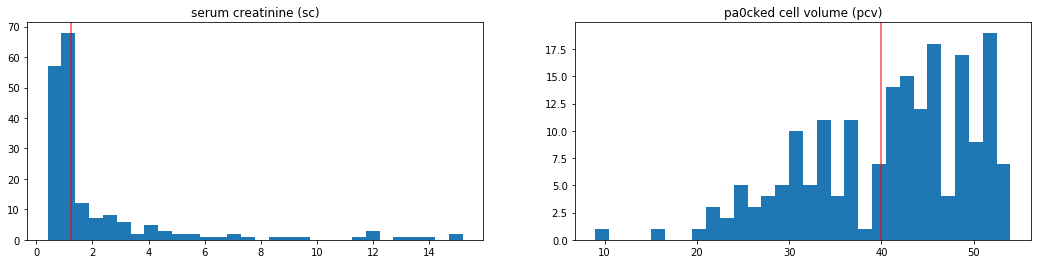

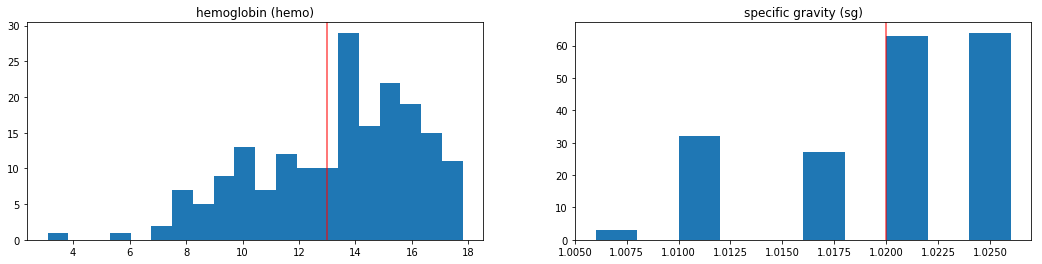

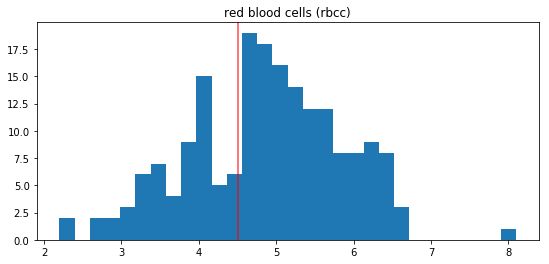

In [28]:
plt.figure(figsize=(18,4))

plt.subplot(121)
plt.hist(data['sc'], bins=30)
plt.axvline(1.25,0,70, color='r', alpha=0.7)
plt.title('serum creatinine (sc)')

plt.subplot(122)
plt.hist(data['pcv'], bins=30)
plt.axvline(40,0,20, color='r', alpha=0.7)
plt.title('pa0cked cell volume (pcv)')
plt.show()

plt.figure(figsize=(18,4))

plt.subplot(121)
plt.hist(data['hemo'], bins=20)
plt.axvline(13,0,16, color='r', alpha=0.7)
plt.title('hemoglobin (hemo)')

plt.subplot(122)
plt.hist(data['sg'], bins=10,align='right')
plt.axvline(1.02,0,60, color='r', alpha=0.7)
plt.title('specific gravity (sg)')
plt.show()

plt.figure(figsize=(9,4))
plt.hist(data['rbcc'], bins=30,align='right')
plt.axvline(4.5,0,20, color='r', alpha=0.7)
plt.title('red blood cells (rbcc)')
plt.show()

#### En pratique
 
Si un ensemble de valeurs ont des fréquences similaires alors on les mets dans une même catégorie.

Nous séparons la colonne sc en deux colonnes sc0-1.25 et sc1.25-Inf. Si un patient a une valeur de serum creatinine compris entre 0 et 1.25 il aura 1 dans la colonne sc0-1.25 et 0 dans la colonne sc1.25-Inf (et inversement).

### Choix des caractéristiques <a name="choix"></a>

Au début nous avons regardé les correlations qui existent entre les différentes variables. Celles qui sont liés à la maladie étaient principalement sg hemo pcv rbcc htn dm al et sc.  

Nous avons utilisé un modèle de Random Forest et recensé les caractéristiques les plus influentes. Dans la figure suivante nous avons trouvés presque les même caractéristiques en tête.

Puis nous avons lancé le classifieur sur 10 combinaisons différentres train/test générés aléatoirement. Dans les règles obtenus après classement, htn et al ne sont jamais utilisés. Donc nous n'avons gardé que les 6 restantes. Nous les avons binarisés comme décrit sur les histogrammes précédents. 

### Complexité <a name="complexité"></a>

### Etude des règles obtenues <a name="règles"></a>

### Performances <a name="score"></a>

In [16]:
include("src/main.jl")

=== Creating the features
=== ... 126 individuals in the train set
=== ... 63 individuals in the test set
=== ... 12 features
=== Generating the rules
-- Classe 0


LoadError: MethodError: no method matching Model(::Type{CPLEX.Optimizer})
Closest candidates are:
  Model(::Any, !Matched::Symbol, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Int64, !Matched::Array{String,1}, !Matched::Array{String,1}, !Matched::Array{Float64,1}, !Matched::Array{Float64,1}, !Matched::Array{Symbol,1}, !Matched::Array{T,1} where T, !Matched::Array{Tuple{Symbol,Any},1}, !Matched::Any, !Matched::Any, !Matched::Array{Float64,1}, !Matched::Array{Float64,1}, !Matched::Array{Float64,1}, !Matched::Array{Float64,1}, !Matched::Array{Array{Int64,1},1}, !Matched::Array{Array{Tuple{Int64,Int64},1},1}, !Matched::Any, !Matched::MathProgBase.SolverInterface.AbstractMathProgSolver, !Matched::Bool, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Array{T,1} where T, !Matched::JuMP.IndexedVector{Float64}, !Matched::Any, !Matched::Bool, !Matched::Dict{Symbol,Any}, !Matched::IdDict, !Matched::Int64, !Matched::Int64, !Matched::Dict{Symbol,Any}) at C:\Users\walid\packages\JuMP\I7whV\src\JuMP.jl:87
  Model(::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any) at C:\Users\walid\packages\JuMP\I7whV\src\JuMP.jl:87
  Model(; solver, simplify_nonlinear_expressions) at C:\Users\walid\packages\JuMP\I7whV\src\JuMP.jl:168

## Influence des caractéristiques <a name="binarisation_influence"></a>

Nous allons comparer l'ajout et la suppression d'une caractéristique sur les performances du classifieur.

## Optimisation bi-objectif <a name="biobjectif"></a>

Nous allons résoudre le problème de génération de règle par l'optimisation bi-objectif où nous minimisons la couverture de la règle et maximisons le nombre d'éléments d'une certaine classe pour lesquels la règle s'applique. Nous récupérons donc pour chaque classe un ensemble de règles non dominées.

### Observations

Cette méthode est beaucoup plus rapide même si nous binarisons plus de caractéristiques. Et ceci donne peu de règles à appliquer.

## Comparaison à des méthodes de machine learning usuelles <a name="compML"></a>

Nous avons testés de répondre à ce problème de classification par des méthodes usuelles: Arbre CART, random forest, linearisation, Adaptive Boosting.
Nous avons comparés ces différentes méthodes avec le classifieur ORC et ceci sur 10 combinaisons différentes train/test.

## Méthode ORC appliquée à du multi-classes <a name="multiclasses"></a>

Le classifieur ORC s'applique si on s'intéresse à faire du multi-classes. Ceci vient du fait que pour chaque classe nous pouvons générer des règles qui s'appliquent à cette classe là. 

Nous avons testé ceci sur la prédiction de la valeur de sg (specific gravity) qui contient 5 valeurs différentes possibles.